<a href="https://colab.research.google.com/github/arun3031143/pdecode/blob/main/python_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1992106376.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_controlled[i] = u


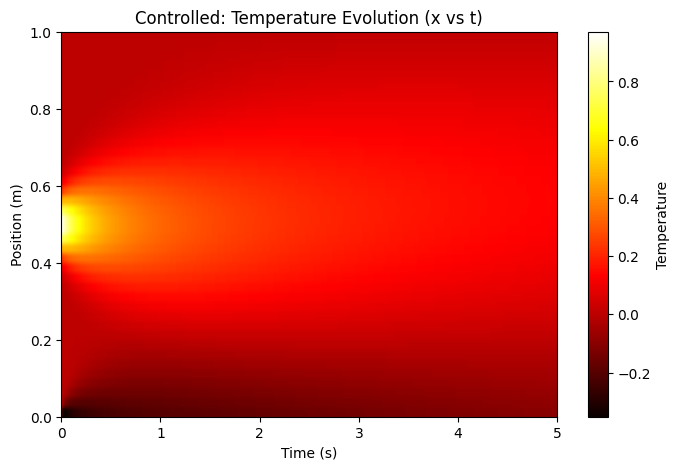

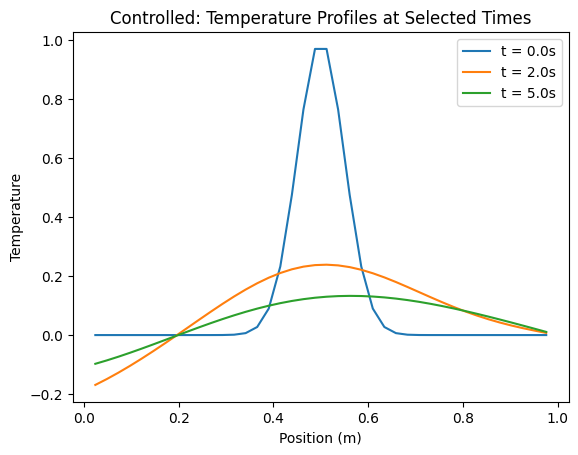

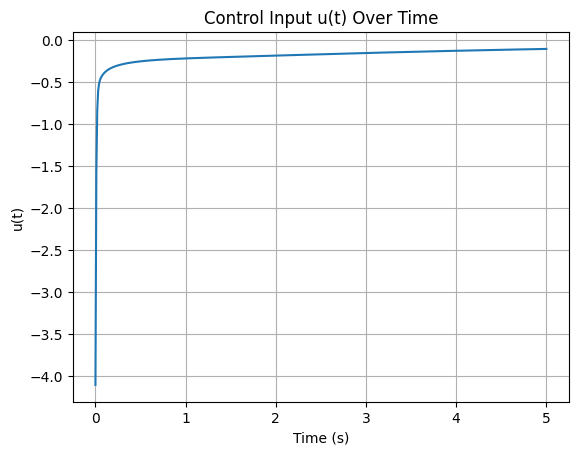

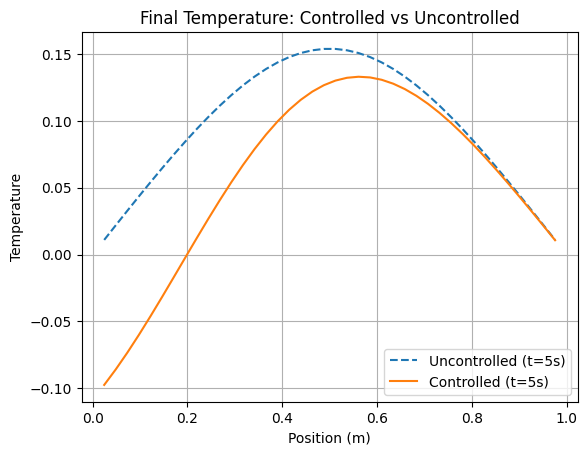

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

# Parameters
L = 1.0           # rod length (m)
alpha = 0.01      # thermal diffusivity
N = 40            # spatial nodes
dx = L / (N + 1)

# Discretize Laplacian
A = np.zeros((N, N))
for i in range(N):
    A[i, i] = -2
    if i > 0:
        A[i, i - 1] = 1
    if i < N - 1:
        A[i, i + 1] = 1
A *= alpha / dx**2

# Control input at left boundary
B = np.zeros((N, 1))
B[0] = alpha / dx**2

# Initial condition: Gaussian
x_space = np.linspace(dx, L - dx, N)
x0 = np.exp(-((x_space - 0.5) ** 2) / (2 * 0.05 ** 2))

# LQR Design
Q = np.eye(N)
R = np.array([[0.01]])
P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ B.T @ P

# Simulation settings
dt = 0.01
t_final = 5.0
steps = int(t_final / dt) + 1
time = np.linspace(0, t_final, steps)

# Controlled simulation
X_controlled = np.zeros((steps, N))
u_controlled = np.zeros(steps)
x = x0.copy()
for i in range(steps):
    X_controlled[i] = x
    u = -K @ x
    u_controlled[i] = u
    dx1 = A @ x + (B * u).flatten()
    dx2 = A @ (x + 0.5 * dt * dx1) + (B * (-K @ (x + 0.5 * dt * dx1))).flatten()
    dx3 = A @ (x + 0.5 * dt * dx2) + (B * (-K @ (x + 0.5 * dt * dx2))).flatten()
    dx4 = A @ (x + dt * dx3) + (B * (-K @ (x + dt * dx3))).flatten()
    x = x + dt / 6 * (dx1 + 2*dx2 + 2*dx3 + dx4)

# Uncontrolled simulation
X_uncontrolled = np.zeros((steps, N))
x = x0.copy()
for i in range(steps):
    X_uncontrolled[i] = x
    dx1 = A @ x
    dx2 = A @ (x + 0.5 * dt * dx1)
    dx3 = A @ (x + 0.5 * dt * dx2)
    dx4 = A @ (x + dt * dx3)
    x = x + dt / 6 * (dx1 + 2*dx2 + 2*dx3 + dx4)

# Plot 1: Heatmap
plt.figure(figsize=(8, 5))
plt.imshow(X_controlled.T, aspect='auto', origin='lower',
           extent=[0, t_final, 0, L], cmap='hot')
plt.colorbar(label="Temperature")
plt.title("Controlled: Temperature Evolution (x vs t)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.show()

# Plot 2: Snapshots
snapshot_times = [0.0, 2.0, 5.0]
snapshot_idxs = [int(t / dt) for t in snapshot_times]
plt.figure()
for t, idx in zip(snapshot_times, snapshot_idxs):
    plt.plot(x_space, X_controlled[idx], label=f"t = {t:.1f}s")
plt.title("Controlled: Temperature Profiles at Selected Times")
plt.xlabel("Position (m)")
plt.ylabel("Temperature")
plt.legend()
plt.show()

# Plot 3: Control Input
plt.figure()
plt.plot(time, u_controlled)
plt.title("Control Input u(t) Over Time")
plt.xlabel("Time (s)")
plt.ylabel("u(t)")
plt.grid(True)
plt.show()

# Plot 4: Controlled vs Uncontrolled
plt.figure()
plt.plot(x_space, X_uncontrolled[-1], '--', label="Uncontrolled (t=5s)")
plt.plot(x_space, X_controlled[-1], '-', label="Controlled (t=5s)")
plt.title("Final Temperature: Controlled vs Uncontrolled")
plt.xlabel("Position (m)")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()
